
# Linear regression example using Spike-Slab Prior

The model equation is y = ax + b with a, b being the model parameters, while the
likelihood model is based on a normal zero-mean additive model error distribution. The problem is solved via sampling using emcee.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

We start by generating a synthetic data set from a known linear model to which we will
add some noise.



In [2]:
# ground truth that is to be inferred
a_true = 8
b_true = 10

# settings for data generation
n_tests = 50
seed = 1
mean_noise = 0.0
std_noise = 1 # is assumed to be known and is not inferred.

# generate the data
np.random.seed(seed)
x_test = np.linspace(-4.0, 4.0, n_tests)
y_true = a_true * x_test + b_true #a_true * x_test**2 #+ b_true * x_test + c_true #a_true * x_test**2 + 
y_test = y_true + np.random.normal(loc=mean_noise, scale=std_noise, size=n_tests)

Let's take a look at the data that we just generated:



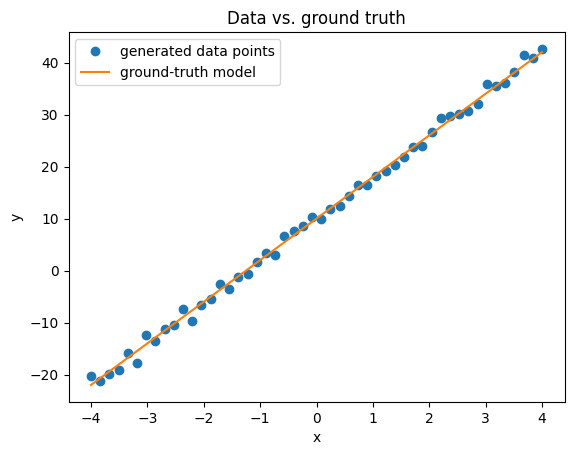

In [3]:
plt.plot(x_test, y_test, "o", label="generated data points")
plt.plot(x_test, y_true, label="ground-truth model")
#plt.plot(x_test, - 2*x_test , label="ground-truth model") #1*np.exp(x_test)
plt.title("Data vs. ground truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Starting values for the parameters are selected using priors. Parameters.json file contatins the list of parameters and their definition.



In [4]:
import json
with open('parameters_uniform_hyperprior.json', 'r') as f: 
    json_object = json.loads(f.read()) 

nwalkers = 20
ndim = len(json_object.get('parameters')) 
from scipy.stats import invgamma, halfcauchy, norm, bernoulli, uniform
start_parameters = np.zeros((nwalkers, ndim))
counter = 0

# This loop reads the parameters from the json file and samples from the prior distributions
for index, parameter in enumerate(json_object.get('parameters')):
    #if parameter['prior'][0] == 'Bernoulli':
    #    start_parameters[:, index] = bernoulli.rvs(p = parameter['prior'][1]["p"], size=nwalkers)
    #elif parameter['prior'][0] == 'Spike-Slab':
    #    for hyperparameter in parameter['hyperparameters']:
    #        for ind, param in enumerate(json_object.get('parameters')):
    #            if hyperparameter == param['name']:
    #                lmbda = start_parameters[:, ind]
    #    start_parameters[:, index] = lmbda*norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"], size=nwalkers) 
    if parameter['prior'][0] == 'Normal': 
        start_parameters[:, index] = norm.rvs(loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"], size=nwalkers) 
    elif parameter['prior'][0] == 'Uniform':   
        start_parameters[:, index] = uniform.rvs(loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"], size=nwalkers)   


Defining the log likelihood, log prior functions and using emcee to run the inference problem.

In [5]:
def log_likelihood(theta, _x_test, _y_test, _sigma):

    y_model = (0 if theta[0] <= 0.5 else 1)*theta[1] * _x_test + \
        (0 if theta[2] <= 0.5 else 1)*theta[3] + \
        (0 if theta[4] <= 0.5 else 1)*theta[5] * np.square(_x_test)
    
    return -0.5 * np.sum((_y_test - y_model) ** 2 / _sigma**2 + np.log(_sigma**2))

def log_prior(theta):
    _lp = 0
    # This loop reads the parameters from the json file and calulates the log prior.
    for index, parameter in enumerate(json_object.get('parameters')):
        if parameter['prior'][0] == 'Normal': 
            _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"]) 

        elif parameter['prior'][0] == 'Uniform':   
            _lp += uniform.logpdf(theta[index], loc = parameter['prior'][1]["lower_bound"], scale = parameter['prior'][1]["lower_bound"] + parameter['prior'][1]["upper_bound"])    
        #if parameter['prior'][0] == 'Bernoulli':
        #    ## Uncomment the following lines to see the change in trace of the Bernoulli parameters.
        #    #if theta[index] >= 0.3:
        #    #    theta[index] = 1
        #    #else:
        #    #    theta[index] = 0
        #    if theta[index] < 0.0 or theta[index] > 1.0:
        #        return -np.inf
        #    _lp += bernoulli.logpmf(0 if theta[index] < 0.5 else 1, p = parameter['prior'][1]["p"])            
        #    #_lp += bernoulli.logpmf(theta[index], p = parameter['prior'][1]["p"])
        #elif parameter['prior'][0] == 'Spike-Slab':
        #    for hyperparameter in parameter['hyperparameters']:
        #        for ind, param in enumerate(json_object.get('parameters')):
        #            if hyperparameter == param['name']:
        #                lmbda = theta[ind]
        #                #if lmbda < 0.0 or lmbda > 1.0:
        #                #    return -np.inf
        #    #_lp += lmbda*norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"]) 
        #    #_lp += lmbda*norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["variance"])
        #    if lmbda >= 0.5:
        #        _lp += norm.logpdf(theta[index], loc = parameter['prior'][1]["mean"], scale = parameter['prior'][1]["std_dev"])
        #    elif lmbda < 0.5:
        #        theta[index] = 0
        #        _lp += 0
        #    #else:
        #    #    return -np.inf
    return _lp
            

def log_probability(theta, _x_test, _y_test, _std_noise):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, _x_test, _y_test, _std_noise)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x_test, y_test, std_noise))
sampler.run_mcmc(start_parameters, 3000, progress=True)

100%|██████████| 3000/3000 [00:21<00:00, 138.62it/s]


State([[ 8.43335855e-01  8.10445791e+00  9.17551012e-01  9.94075737e+00
   3.22461495e-01  4.16450991e+00]
 [ 7.45270729e-01  8.07085962e+00  6.24087954e-01  9.87169205e+00
   4.82961605e-01 -9.54350164e+00]
 [ 6.09481342e-01  8.13374425e+00  7.94999673e-01  1.03165875e+01
   2.17703793e-01 -4.52375694e+00]
 [ 7.89194899e-01  7.94082413e+00  8.21117409e-01  9.97112450e+00
   4.23503588e-01 -1.38037592e+01]
 [ 5.49336709e-01  7.98248816e+00  6.16358363e-01  9.97561247e+00
   2.50784678e-02  1.11470003e+00]
 [ 8.37551485e-01  7.97436909e+00  5.71314262e-01  1.02873168e+01
   2.99010937e-01 -1.15549100e+01]
 [ 8.29939583e-01  8.02010699e+00  8.29384298e-01  1.00629539e+01
   3.93189109e-02  7.78481253e+00]
 [ 9.30855658e-01  8.01221446e+00  8.53244829e-01  9.92658866e+00
   3.45490898e-01 -3.32693659e+00]
 [ 9.65943973e-01  8.09549291e+00  6.55973878e-01  9.94942841e+00
   3.18191068e-01  3.72072261e+00]
 [ 9.35174427e-01  8.12454602e+00  5.74932104e-01  9.93356237e+00
   1.17311433e-01  

Plotting the trace of the chain

Text(0.5, 0, 'step number')

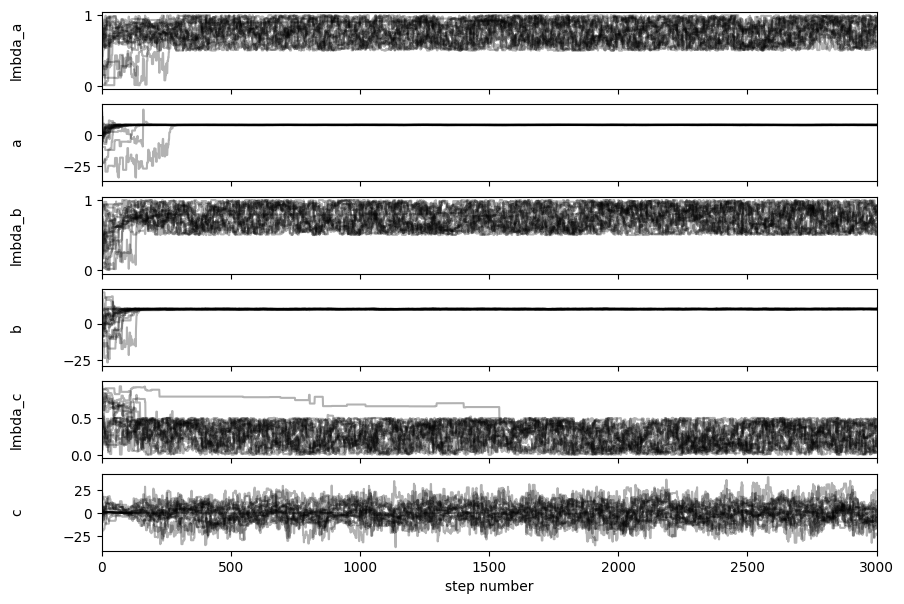

In [6]:
fig1, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c"] # Change the labels over here if changes in parameters are made in json file.
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Plotting the pair-plot of the chain.

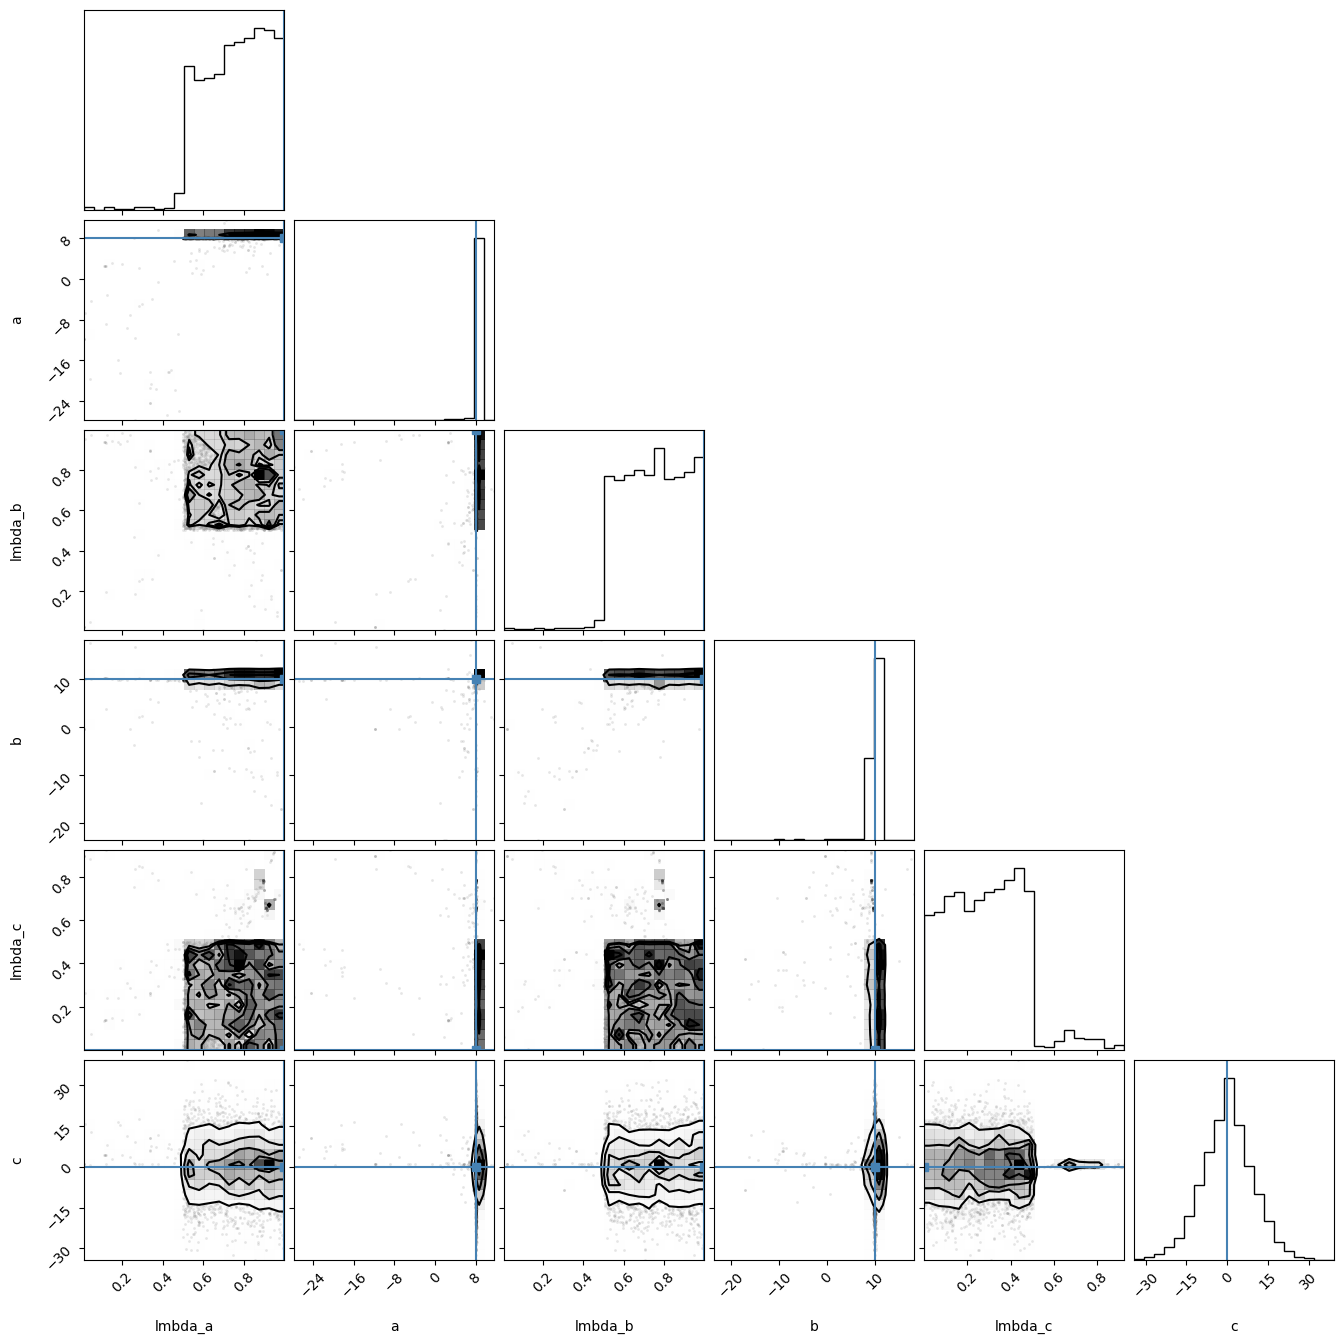

In [7]:
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
import corner
fig2 = corner.corner(
    flat_samples, labels=labels, truths=[1, 8, 1, 10, 0, 0]
)

Plotting with rounded off parameters

In [8]:
sample_shape = samples.shape
rounded_off_samples = np.zeros((sample_shape[0], sample_shape[1], sample_shape[2]))
for arr_ind_i, matrix in enumerate(samples):
    for arr_ind_j, row in enumerate(matrix):
        #print(row.shape)
        for arr_ind_k, element in enumerate(row[0:-1:2]):
                #print(arr_ind_k)
                #if arr_ind_k%2 == 0 and element < 0.5:
                if element < 0.5:
                    rounded_off_samples[arr_ind_i,arr_ind_j,2*arr_ind_k] = 0
                    rounded_off_samples[arr_ind_i,arr_ind_j,2*arr_ind_k+1] = 0
                else:
                    rounded_off_samples[arr_ind_i,arr_ind_j,2*arr_ind_k] = 1

Text(0.5, 0, 'step number')

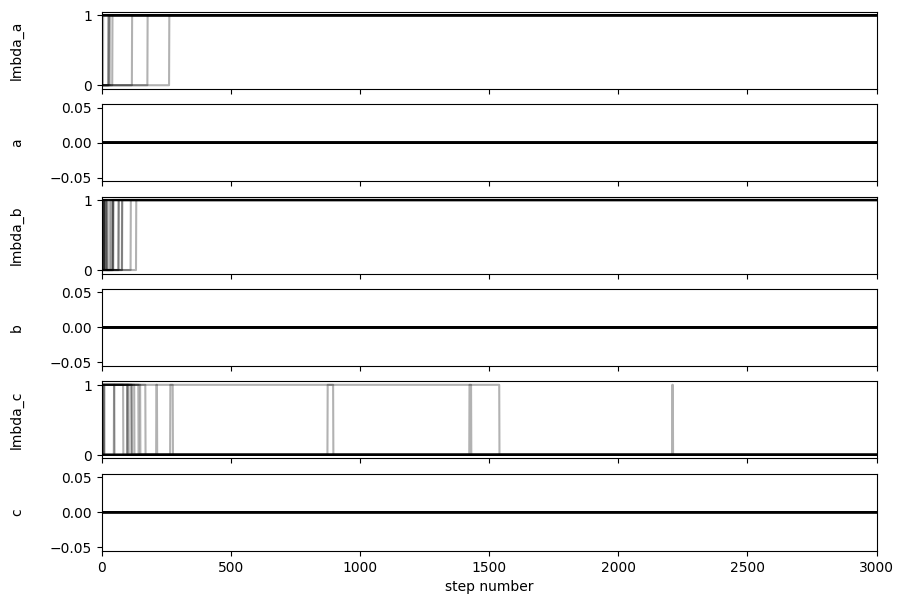

In [9]:
fig3, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["lmbda_a", "a", "lmbda_b", "b", "lmbda_c", "c", ]
for i in range(ndim):
    ax = axes[i]
    ax.plot(rounded_off_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(rounded_off_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")